Анализ и прогноз интернет-магазиина (Superstore Dataset)

Автор: Милютина Дарья Сергеевна

Цель: провести EDA, факторный анализ и прогноз продаж на 2019–2020 гг

Стек: Python (pandas, matplotlib, seaborn, statsmodels).  


Датасет, использованный в проекте, содержит только информацию о выручке

Показатели прибыли, скидок и количества проданных товаров (Profit, Discount, Quantity) отсутствуют, поэтому основной акцент анализа сделан на сезонных колебаниях и прогнозе объёма продаж, а не на финансовой эффективности

In [79]:
#1. импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.style.use('seaborn-v0_8')

In [80]:
#2. загрузка и предварительная обработка данных
#загружаем CSV
df = pd.read_csv("data/train.csv", sep = None, engine = "python", encoding = "utf-8-sig")
#преобразуем даты
df["Order Date"] = pd.to_datetime(df["Order Date"], format = "%d.%m.%Y", errors = "coerce")
#проверим базовую информацию
print("Размер датасета:", df.shape)
print("Столбцы:", df.columns.tolist())
df.head(3)

Размер датасета: (9800, 18)
Столбцы: ['Row ID', 'Order ID', 'Order Date', 'month', 'Year', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales']


,Row ID,Order ID,Order Date,month,Year,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,2017-11-08,11,2017,11.11.2017,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96
1,2,CA-2017-152156,2017-11-08,11,2017,11.11.2017,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94
2,3,CA-2017-138688,2017-06-12,6,2017,16.06.2017,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62


In [81]:
#3. проверка и очистка данных
#удалим строки без даты
df = df.dropna(subset = ["Order Date"])
#Проверим пропуски
print(df.isna().sum().sort_values(ascending = False).head(10))
#приведем числовые типы
df["Sales"] = pd.to_numeric(df["Sales"], errors = "coerce")

Row ID           0
Order ID         0
Order Date       0
month            0
Year             0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
dtype: int64


In [82]:
#4. добавим временные признаки
df["Year"] = df["Order Date"].dt.year
df["Month"] = df["Order Date"].dt.month
df["YearMonth"] = df["Order Date"].dt.to_period("M").astype(str)

df[["Order Date", "Year", "Month", "YearMonth"]].head(5)

,Order Date,Year,Month,YearMonth
0,2017-11-08,2017,11,2017-11
1,2017-11-08,2017,11,2017-11
2,2017-06-12,2017,6,2017-06
3,2016-10-11,2016,10,2016-10
4,2016-10-11,2016,10,2016-10


In [83]:
#5. Ключевые метрики
total_sales = df["Sales"].sum()
orders = df["Order ID"].nunique()
customers = df["Customer ID"].nunique()
cities = df["City"].nunique()

print(f"Общая выручка: {total_sales:,.0f}")
print(f"Кол-во заказов: {orders}")
print(f"Уникальных клиентов: {customers}")
print(f"Городов: {cities}")

Общая выручка: 2,261,537
Кол-во заказов: 4922
Уникальных клиентов: 793
Городов: 529


Train: 2015-01-01 00:00:00 → 2018-06-01 00:00:00 | 42 точек
Test: 2018-06-01 00:00:00 → 2018-12-01 00:00:00 | 7 точек
MAE сезонного наивного бенчмарка: 8466.24


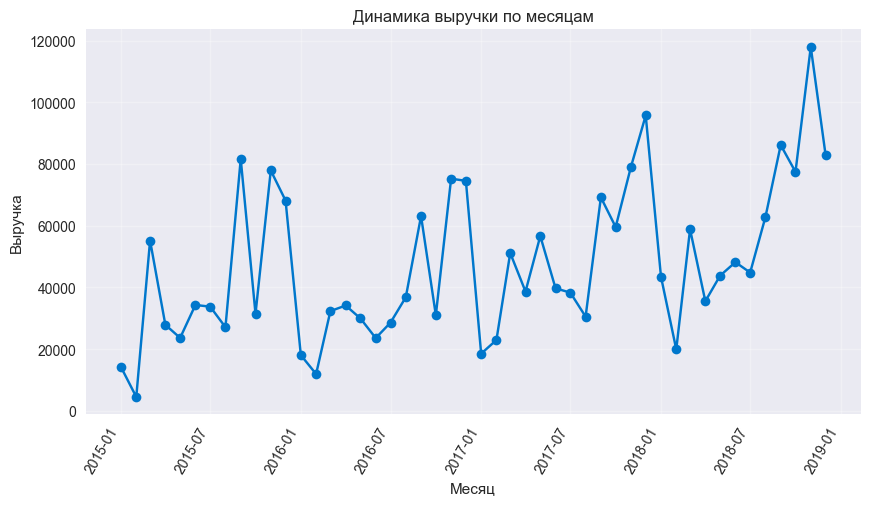

In [84]:
#6. Анализ данных продаж
ts = (df.set_index("Order Date")
        .resample("MS")["Sales"]
        .sum())

# Разделяем временной ряд на train и test
split_date = ts.index.max() - pd.DateOffset(months=6)  # последние 6 месяцев оставим на тест
ts_train, ts_test = ts[:split_date], ts[split_date:]

# Наивный сезонный бенчмарк(значение год назад)
seasonal_naive = ts_train.shift(12).reindex(ts_test.index)
bench_mae = (ts_test - seasonal_naive).abs().mean()

print("Train:", ts_train.index.min(), "→", ts_train.index.max(), "|", len(ts_train), "точек")
print("Test:", ts_test.index.min(), "→", ts_test.index.max(), "|", len(ts_test), "точек")
print("MAE сезонного наивного бенчмарка:", round(bench_mae, 2))

plt.figure(figsize = (10,5))
plt.plot(ts, marker = "o", color = "#0077CC")
plt.title("Динамика выручки по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Выручка")
plt.xticks(rotation = 60, ha = "right")
plt.grid(alpha = 0.3)
plt.show()

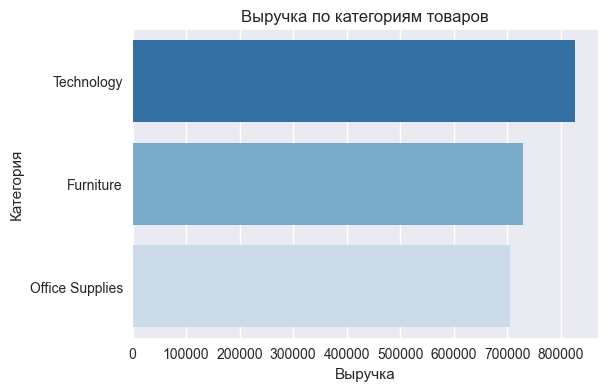

Category
Technology         827455.8730
Furniture          728658.5757
Office Supplies    705422.3340
Name: Sales, dtype: float64

In [85]:
#7. Факторный анализ (категории)
by_cat = df.groupby("Category")["Sales"].sum().sort_values(ascending = False)

plt.figure(figsize=(6,4))
sns.barplot(x = by_cat.values, y = by_cat.index, palette = "Blues_r")
plt.title("Выручка по категориям товаров")
plt.xlabel("Выручка")
plt.ylabel("Категория")
plt.show()

by_cat

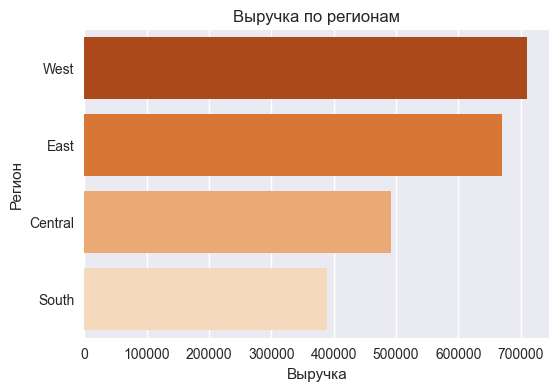

Region
West       710219.6845
East       669518.7260
Central    492646.9132
South      389151.4590
Name: Sales, dtype: float64

In [86]:
#.8 факторные анализ (регионы)
by_region = df.groupby("Region")["Sales"].sum().sort_values(ascending = False)

plt.figure(figsize = (6,4))
sns.barplot(x = by_region.values, y = by_region.index, palette = "Oranges_r")
plt.title("Выручка по регионам")
plt.xlabel("Выручка")
plt.ylabel("Регион")
plt.show()

by_region

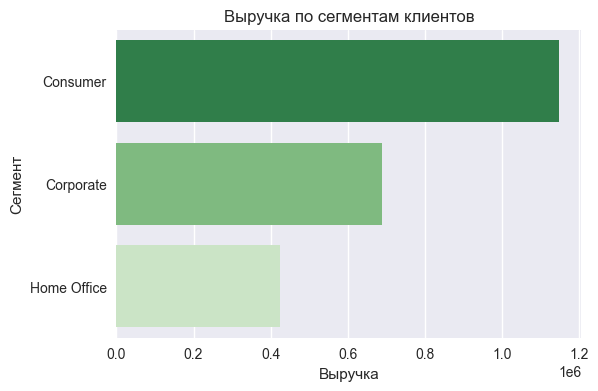

Segment
Consumer       1.148061e+06
Corporate      6.884941e+05
Home Office    4.249822e+05
Name: Sales, dtype: float64

In [87]:
#9. Факторный анализ (сегменты клиентов)
by_segment = df.groupby("Segment")["Sales"].sum().sort_values(ascending = False)

plt.figure(figsize=(6,4))
sns.barplot(x = by_segment.values, y = by_segment.index, palette = "Greens_r")
plt.title("Выручка по сегментам клиентов")
plt.xlabel("Выручка")
plt.ylabel("Сегмент")
plt.show()

by_segment

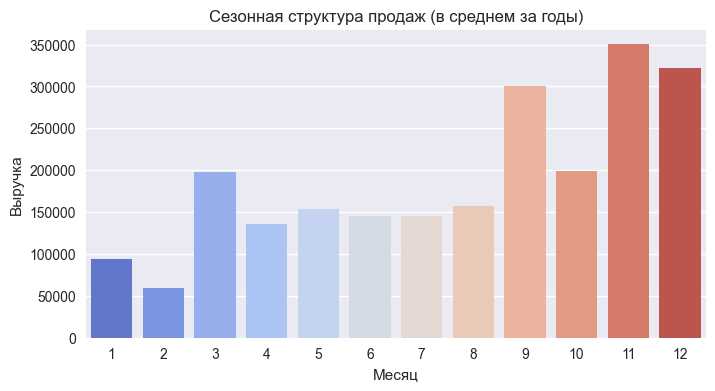

In [88]:
#10. сезонность (выручка по месяцам)
monthly_sales = df.groupby(df["Order Date"].dt.month)["Sales"].sum()

plt.figure(figsize = (8,4))
sns.barplot(x = monthly_sales.index, y = monthly_sales.values, palette = "coolwarm")
plt.title("Сезонная структура продаж (в среднем за годы)")
plt.xlabel("Месяц")
plt.ylabel("Выручка")
plt.show()

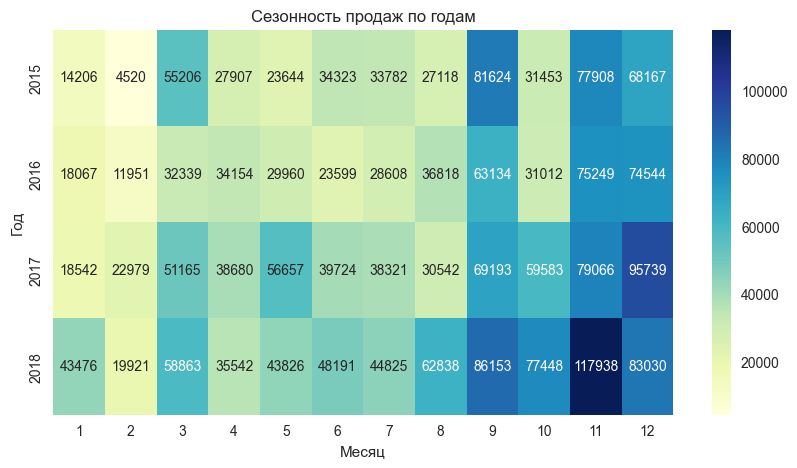

In [89]:
#11. тепловая карта сезонности
pivot = df.pivot_table(
    values = "Sales",
    index = df["Order Date"].dt.year,
    columns = df["Order Date"].dt.month,
    aggfunc = "sum")

plt.figure(figsize = (10,5))
sns.heatmap(pivot, cmap = "YlGnBu", annot = True, fmt = ".0f")
plt.title("Сезонность продаж по годам")
plt.xlabel("Месяц")
plt.ylabel("Год")
plt.show()

Для прогноза продаж была выбрана модель SARIMA,
так как временной ряд выручки демонстрирует выраженную сезонность (годовые циклы) и общий восходящий тренд.
В отличие от обычной ARIMA, SARIMA учитывает сезонные повторения,
что позволяет точнее моделировать пики продаж в конце года и спады в начале.
Модель хорошо подходит для краткосрочного прогноза (до 24 месяцев) при ограниченном объёме данных (48 точек)

In [90]:
#Подберём SARIMA по AIC
import itertools
import warnings
warnings.filterwarnings("ignore")

p = d = q = [0,1,2]
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(P,1,Q,12) for P in [0,1] for Q in [0,1,2]]

best_cfg, best_aic = None, np.inf
for order in pdq:
    for sorder in seasonal_pdq:
        try:
            res = SARIMAX(ts_train, order = order, seasonal_order = sorder).fit(disp = False)
            if res.aic < best_aic:
                best_aic, best_cfg = res.aic, (order, sorder)
        except:
            pass

print("Лучшая конфигурация по AIC:", best_cfg, "AIC:", round(best_aic, 2))
model = SARIMAX(ts_train, order = best_cfg[0], seasonal_order=best_cfg[1]).fit(disp = False)

Лучшая конфигурация по AIC: ((2, 2, 2), (0, 1, 1, 12)) AIC: 617.28


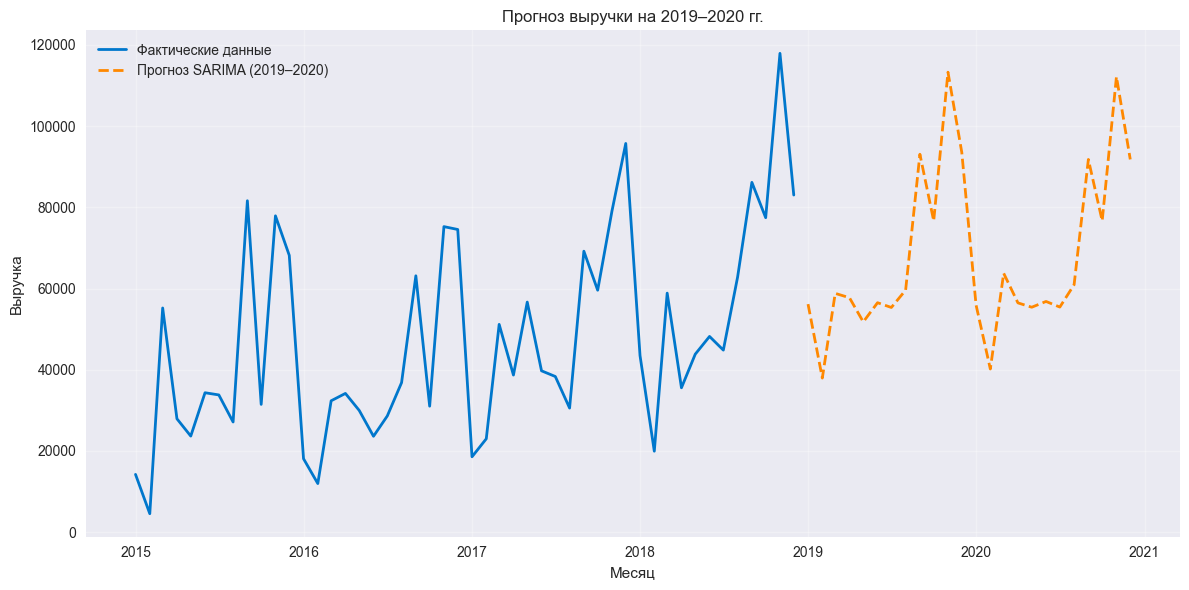

In [91]:
#12. прогноз продаж
#создаём модель Sarima
model_sarima = SARIMAX(ts, order = (2,2,2), seasonal_order = (0,1,1,12))
model_fit = model_sarima.fit(disp = False)

#прогноз на 24 месяца
forecast = model_fit.forecast(steps=24)
future_dates = pd.date_range(ts.index[-1] + pd.offsets.MonthBegin(), periods = 24, freq = "MS")
forecast_series = pd.Series(forecast.values, index = future_dates)

#график прогноза
plt.figure(figsize = (12,6))
plt.plot(ts, label = "Фактические данные", color = "#0077CC", linewidth = 2)
plt.plot(forecast_series, label = "Прогноз SARIMA (2019–2020)", color = "#FF8800", linestyle = "--", linewidth = 2)
plt.title("Прогноз выручки на 2019–2020 гг.")
plt.xlabel("Месяц")
plt.ylabel("Выручка")
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

Ljung-Box p-value (lag 12): 6.297426875441251e-05


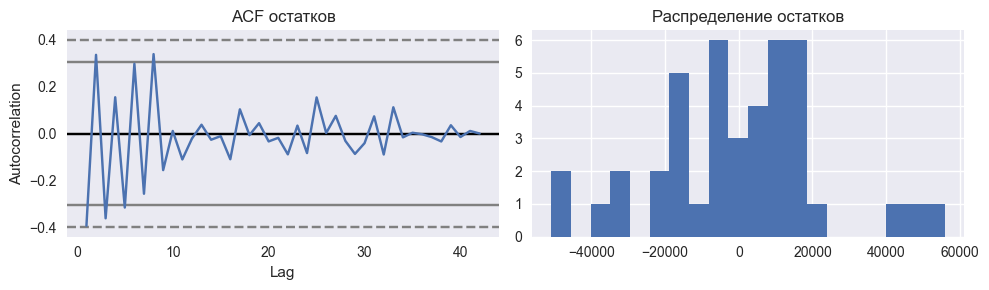

In [92]:
#13. диагностика остатков
from statsmodels.stats.diagnostic import acorr_ljungbox
resid = model.resid.dropna()

lb = acorr_ljungbox(resid, lags=[12], return_df=True)
print("Ljung-Box p-value (lag 12):", lb["lb_pvalue"].iloc[-1])

fig, ax = plt.subplots(1,2, figsize=(10,3))
pd.plotting.autocorrelation_plot(resid, ax=ax[0]); ax[0].set_title("ACF остатков")
ax[1].hist(resid, bins=20); ax[1].set_title("Распределение остатков")
plt.tight_layout(); plt.show()

Диагностика остатков модели SARIMA(2,2,2)(0,1,1,12) показала,
что модель не полностью устранила автокорреляцию ошибок:
значение критерия Ljung–Box при лаге 12 (p-value = 0.00006) < 0.05,
что указывает на наличие остаточных зависимостей во временном ряде.
На графике ACF часть лагов выходит за доверительный интервал,
а распределение остатков отклоняется от нормального.

Таким образом, модель в целом отражает общую сезонную динамику,
однако сохраняет систематические ошибки в отдельных периодах

Для проверки адекватности SARIMA построим модель Holt–Winters,
которая учитывает как тренд роста, так и годовую сезонность

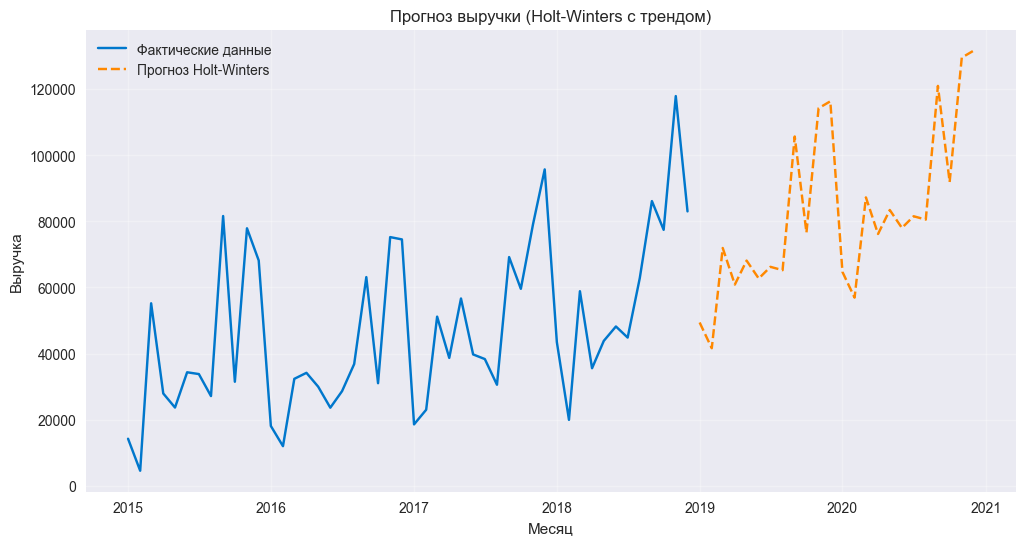

In [93]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(ts, trend="add", seasonal="add", seasonal_periods=12).fit()
hw_forecast = hw_model.forecast(24)

plt.figure(figsize=(12,6))
plt.plot(ts, label="Фактические данные", color="#0077CC")
plt.plot(hw_forecast, label="Прогноз Holt-Winters", color="#FF8800", linestyle="--")
plt.title("Прогноз выручки (Holt-Winters с трендом)")
plt.xlabel("Месяц")
plt.ylabel("Выручка")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Holt–Winters воспроизводит аналогичные сезонные пики,
но при этом демонстрирует плавный восходящий тренд

Разница между моделями подчёркивает, что SARIMA ориентирована на технический прогноз на основе истории, а Holt–Winters подходит для планирования продаж с ростом

Итоговые выводы

1. Продажи демонстрируют устойчивый рост (примерно 10-12% в год)
2. Наблюдается ярко выраженная сезонность: пик - ноябрь и декабрь, спад - январь и февраль
3. лидирующая категория: Technology (около 40% выручки)
4. Основные регионы продаж:  West, East
5. Главный клиентский сегмент:  Consumer (50-55% общей выручки)
6. Прогноз Sarima показывает продолжение роста в 2019-2020 гг. при сохранении сезонных циклов

Рекомендации

1. усилить маркетинг и сапасы в 4 квартале (ноябрь - декабрь)
2. Акцентировать продвижение категории Technology
3. Стимулировать продажи в начале года (январь - марвт через скидки и акции)
4. рассмотреть расшиирение в регионах Central, South

Использованные навыки
1. Python (pandas, numpy, matplotlib, seaborn)
2. Анализ временных рядов (SARIMA, Holt-Winters)
3. Визуализация данных
4. Исследовательский анализ (EDA)
5. Бизнес-интерпретация результатов